# Pendulum with Structured LNN and Control
- We know the data is angle and use it as advantage

## TODO:

- Plot Mass Matrix
- Plot Potential
- Understand the control

In [1]:
import numpy as np
import torch

import sys
import time
sys.path.append("../../")

## Train Model

In [46]:
# hparams
num_ensumble = 20

num_sample = 50
batch_size = num_sample
portion = 0.5

learning_rate = 3e-4
min_delta = 0
patience = 20

time_horizon = 10
solver = 'rk4'

model_name = 'ensumble.pt'
# Check Model params in Model section

### Set Seed Here

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

### Create the data set
- init_condition: list of tuple

 [(x0, p0, t0, t1, steps)]

In [4]:
from gym_env import PendulumCustomEnv
from data import Gym_DataModule_rng

In [5]:
env = PendulumCustomEnv(full_phase=True)
low = np.array([-2])
high = -low

# env, time step, traj, control
dataModule = Gym_DataModule_rng(env,
                                num_sample,
                                low=low,
                                high=high,
                                portion=portion,
                                time_horizon=time_horizon,
                                batch_size=batch_size)

dataModule.setup()

/Users/fei/Documents/UCL/Thesis/Code/MBRL_HNN/experiment/Pendulum/../../data/generate_traj.py:243: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  extra.append(np.array([info['th'], info['dth'], info['ddth']]))


In [6]:
print(dataModule.dataset.tensors[0].shape)  # (bs, time, [cos q, sin, q, dq])
print(dataModule.dataset.tensors[1].shape)  # (bs, time, [control])
print(dataModule.dataset.tensors[2].shape)  # (bs, time, [time])
print(dataModule.dataset.tensors[3].shape)  # (bs, time, [th, dth, ddth])

torch.Size([50, 10, 3])
torch.Size([50, 10, 1])
torch.Size([50, 10, 1])
torch.Size([50, 10, 3])


### Define Model

In [7]:
from torchdyn.models import NeuralODE

from module import LNNODE
from nn import MLP, PSD, MatrixNet

In [8]:
models = []

for i in range(num_ensumble):
    massMatrixNet = PSD([2, 64, 64, 1], activation='sigmoid')
    potentialNet = MLP([2, 64, 64, 1], activation='sigmoid')
    controlNet = MatrixNet([2, 64, 64, 1], control_dim=1, activation='relu')

    lagFunc = LNNODE(num_angle=1, 
                     massMatrixNet=massMatrixNet,
                     potentialNet=potentialNet,
                     controlNet=controlNet)

    lagODE = NeuralODE(lagFunc, sensitivity='adjoint', solver=solver).to(device)
    models.append(lagODE)

### Pretrain with time horizon = 2

In [9]:
import torch.nn.functional as F

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

In [10]:
class Pre_learner(pl.LightningModule):
    def __init__(self, model: torch.nn.Module):
        super().__init__()
        self.model = model
        self.loss_func = F.mse_loss
        self.time_horizon = 3

    def forward(self, x):
        return self.model.defunc(0, x)

    def training_step(self, batch, batch_idx):
        x, u, t, _ = batch
        t_span = t[0, :self.time_horizon, 0]
        q_dq_u = torch.cat([x[:, :self.time_horizon, :], u[:, :self.time_horizon, :]], dim=2)  # Pick (q, dq, u)

        est = self.model.trajectory(q_dq_u[:, 0, :], t_span)

        loss = self.loss_func(q_dq_u, est.transpose(0, 1))
        
        self.logger.experiment.add_scalars("loss", {"train": loss}, self.current_epoch)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=learning_rate)

In [11]:
for i in range(num_ensumble):
    pre_Learn = Pre_learner(models[i])
    pre_trainer = pl.Trainer(max_epochs=500)
    pre_trainer.fit(pre_Learn, dataModule)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
  rank_zero_warn(f'you passed in a {loader_name} but have no {step_name}. Skipping {stage} loop')

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 13.3 K
------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)
/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init 

Training: 0it [00:00, ?it/s]

/Users/fei/Documents/UCL/Thesis/Code/MBRL_HNN/experiment/Pendulum/../../module/LNNODE.py:81: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A.transpose(-2, -1).conj()).transpose(-2, -1).conj() (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1623459044803/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1284.)
  L = torch.cholesky(self.massMatrixNet(q))
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 13.3 K
------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 13.3 K
------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 13.3 K
------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 13.3 K
------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 13.3 K
------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 13.3 K
------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 13.3 K
------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 13.3 K
------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 13.3 K
------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 13.3 K
------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 13.3 K
------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 13.3 K
------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 13.3 K
------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 13.3 K
------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 13.3 K
------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 13.3 K
------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 13.3 K
------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 13.3 K
------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 13.3 K
------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

### Define Pytorch lightning trainer

In [12]:
class Learner(pl.LightningModule):
    def __init__(self, model: torch.nn.Module):
        super().__init__()
        self.model = model
        self.loss_func = F.mse_loss

    def forward(self, x):
        return self.model.defunc(0, x)

    def training_step(self, batch, batch_idx):
        x, u, t, _ = batch
        t_span = t[0, :, 0]
        q_dq_u = torch.cat([x[:, :, :], u[:, :, :]], dim=2)
        
        est = self.model.trajectory(q_dq_u[:, 0, :], t_span)

        loss = self.loss_func(q_dq_u, est.transpose(0, 1))
        
        self.logger.experiment.add_scalars("loss", {"train": loss}, self.current_epoch)
        return loss

    def validation_step(self, batch, batch_idx):
        x, u, t, _ = batch
        t_span = t[0, :, 0]
        q_dq_u = torch.cat([x[:, :, :], u[:, :, :]], dim=2)
        
        est = self.model.trajectory(q_dq_u[:, 0, :], t_span)

        loss = self.loss_func(q_dq_u, est.transpose(0, 1))
        
        self.log('val_loss', loss)
        self.logger.experiment.add_scalars("loss", {"val": loss}, self.current_epoch)
        return loss
    

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=learning_rate)

### Train

In [13]:
start_time = time.time()

In [14]:
for i in range(num_ensumble):
    learn = Learner(models[i])
    early_stopping = EarlyStopping('val_loss', verbose=False, min_delta=min_delta, patience=patience)
    trainer = pl.Trainer(callbacks=[early_stopping], min_epochs=100, max_epochs=5000)
    trainer.fit(learn, dataModule)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 13.3 K
------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:348: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  rank_zero_warn(
/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:610: LightningDeprecationWarning: Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2 and will be removed in v1.4. Please, create your own `mc = ModelCheckpoint(monitor='your_monitor')` and use it as `Trainer(callbacks=[mc])`.
  warning_cache.deprecation(


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 13.3 K
------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 13.3 K
------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 13.3 K
------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 13.3 K
------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 13.3 K
------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 13.3 K
------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 13.3 K
------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 13.3 K
------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 13.3 K
------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 13.3 K
------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 13.3 K
------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 13.3 K
------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 13.3 K
------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 13.3 K
------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 13.3 K
------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 13.3 K
------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 13.3 K
------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 13.3 K
------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 13.3 K
------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

In [15]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 2634.6907892227173 seconds ---


### Save Model
- Pytorch Lightning model check point is buggy
- Use Pytorch save and load method instead

In [47]:
torch.save(models, 'models/{}'.format(model_name))

## Model Analysis

In [17]:
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator

### Load Model

In [50]:
test_model = torch.load('models/{}'.format(model_name))
# test_model.eval()

AttributeError: 'list' object has no attribute 'eval'

### Generate trajectory with Gym Env

In [19]:
# define testing time stamp
dt = 0.05
full = 1000
t_span = torch.linspace(dt, dt*full, full)

In [32]:
# Generate Trajectory
env.seed(0)
np.random.seed(0)

env = PendulumCustomEnv()
obs = []
infos = []

# control = 2
# controls = np.random.randint(-2, 2 + 1, full+1)
split = 20
controls = np.random.randint(-2, 2 + 1, int(full / split))
controls = np.repeat(controls, split)
# controls = np.zeros_like(controls)

# obs0, _ = env.reset(np.array([3., 1.]))
obs0, _ = env.reset(np.array([3., 0.]))

prev_obs = obs0
for i in range(full):
    obs.append(prev_obs)
    
    next_obs, reward, done, info = env.step(controls[i])
    infos.append(np.array([info['th'], info['dth'], info['ddth']]))
    prev_obs = next_obs

obs = torch.tensor(obs)
infos = torch.tensor(infos)
controls = torch.Tensor(controls).view(-1, 1)

### Generate Prediction

In [33]:
from utils import traj_pred

# Generate prediction
ests = []
est_grads = []
for i in range(num_ensumble):
    q_dq_u = torch.cat([obs, controls], dim=1)
    est_grads.append(test_models[i].defunc(0, q_dq_u.float()))
    ests.append(traj_pred(0.05, test_models[i], obs0, controls))

In [34]:
from scipy.integrate import solve_ivp

def dummy(t, y):
    idx = int(torch.tensor(t) / dt)
    dx1 = np.multiply(-y[1], y[2])
    dx2 = np.multiply(y[0], y[2])
    ddq = -10 * y[0] + controls[idx-1] / 2.
    return [dx1, dx2, ddq]

sol = solve_ivp(dummy, [dt, dt*full], obs0, method='Radau', t_eval=t_span.detach().numpy())

In [35]:
print(sol.y.shape)
print(obs0)
# sol.t

(3, 1000)
[0.14112001 0.9899925  0.        ]


### Check gradient

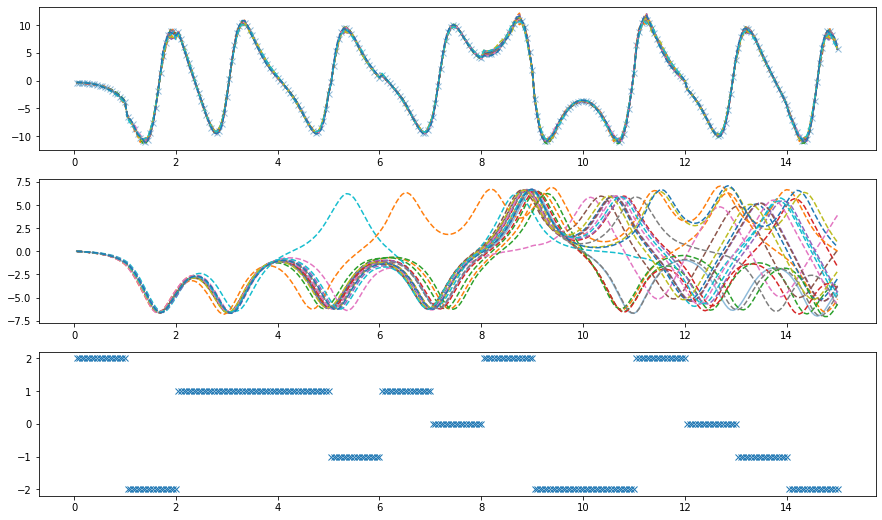

In [36]:
fig = plt.figure(figsize=(15, 9))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

start = 0
end = 300

# Check ddq_est
ax1.plot(t_span.detach().numpy()[start:end], infos[start:end, 2],'x-', alpha=0.5)  # Ground truth
# check dq_est
ax2.plot(t_span.detach().numpy()[start:end], infos[start:end, 1],'-', alpha=0.5)
# ax2.plot(sol.t[start:end], sol.y[2, start:end])

# Plot control for reference
ax3.plot(t_span.detach().numpy()[start:end], controls[start:end],'x')
# None

for i in range(num_ensumble):
    ax1.plot(t_span.detach().numpy()[start:end], est_grads[i][start:end, 2].detach().numpy(), '--')  # LNN
    ax2.plot(t_span.detach().numpy()[start:end], ests[i].y[2, start:end], '--')  # LNN

<ipython-input-42-950102489d0d>:38: RuntimeWarning: invalid value encountered in true_divide
  ci2 = 1.96 * std_dq / mean_dq


(-10.0, 10.0)

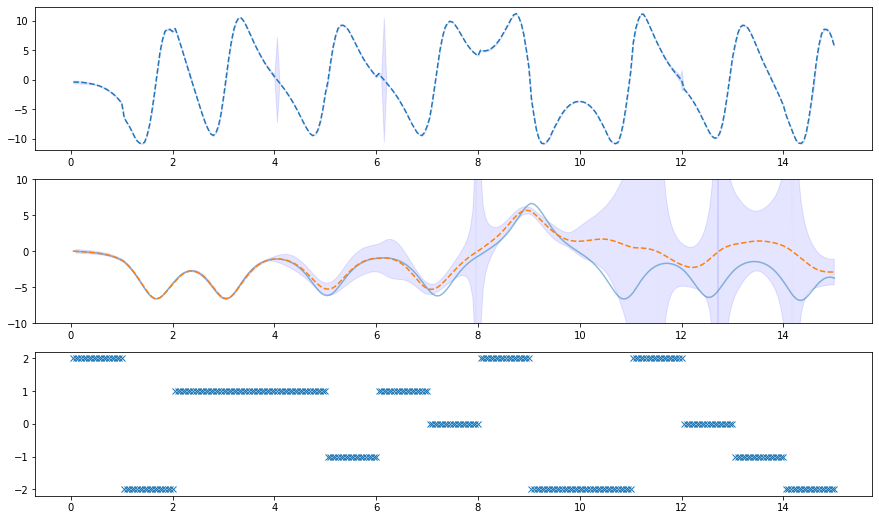

In [42]:
fig = plt.figure(figsize=(15, 9))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

start = 0
end = 300

# Check ddq_est
# ax1.plot(t_span.detach().numpy()[start:end], infos[start:end, 2],'x-', alpha=0.5)  # Ground truth
# check dq_est
# ax2.plot(t_span.detach().numpy()[start:end], infos[start:end, 1],'-', alpha=0.5)
ax2.plot(sol.t[start:end], sol.y[2, start:end], alpha=0.5)

# Plot control for reference
ax3.plot(t_span.detach().numpy()[start:end], controls[start:end],'x')
# None

mean_grad = torch.stack(est_grads, dim=2).mean(2)
std_grad = torch.stack(est_grads, dim=2).std(2)

ax1.plot(t_span.detach().numpy()[start:end], mean_grad[start:end, 2].detach().numpy(), '--')  # LNN
ci = (1.96 * std_grad/mean_grad).detach().numpy()
ax1.fill_between(t_span.detach().numpy()[start:end],
                (mean_grad[start:end, 2].detach().numpy()-ci[start:end, 2]),
                (mean_grad[start:end, 2].detach().numpy()+ci[start:end, 2]),
                color='b',
                alpha=.1)

dqs = []
for i in range(num_ensumble):
    dqs.append(ests[i].y[2, start:end])
    
mean_dq = np.stack(dqs, axis=1).mean(1)
std_dq = np.stack(dqs, axis=1).std(1)

ax2.plot(t_span.detach().numpy()[start:end], mean_dq, '--')  # LNN
ci2 = 1.96 * std_dq / mean_dq
ax2.fill_between(t_span.detach().numpy()[start:end],
                (mean_dq - ci2),
                (mean_dq + ci2),
                color='b',
                alpha=.1)

ax2.set_ylim([-10, 10])

In [38]:
dqs[0].shape

(300,)

### Check trajectory

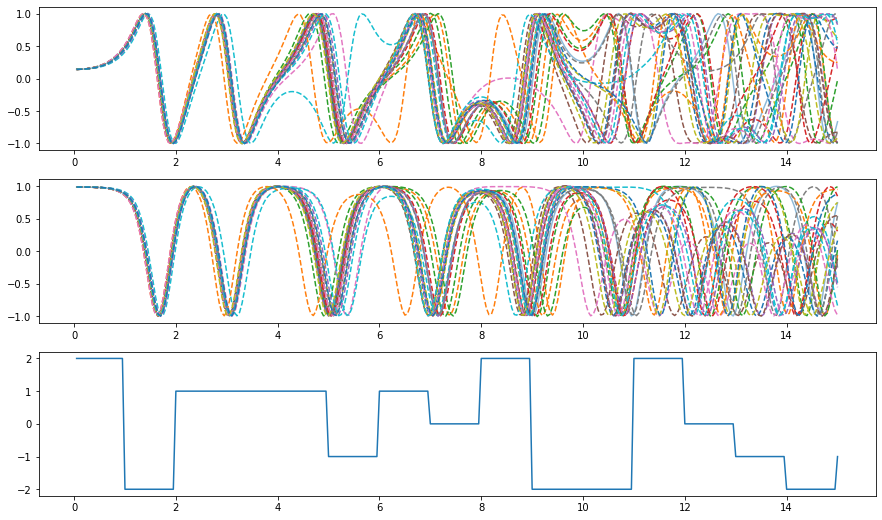

In [39]:
# Check trajectory
start = 0
end = 300

fig = plt.figure(figsize=(15, 9))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

# Plot cos q = x
ax1.plot(t_span.detach().numpy()[start:end], obs[start:end, 0].detach().numpy(), alpha=0.5)

# Plot sin q = y
ax2.plot(t_span.detach().numpy()[start:end], obs[start:end, 1].detach().numpy(), alpha=0.5)

# Plot control for reference
ax3.plot(t_span.detach().numpy()[start:end], controls[start+1:end+1])

for i in range(num_ensumble):
    ax1.plot(t_span.detach().numpy()[start:end], ests[i].y[0, start:end], '--')
    ax2.plot(t_span.detach().numpy()[start:end], ests[i].y[1, start:end], '--')

None

(-1.1, 1.1)

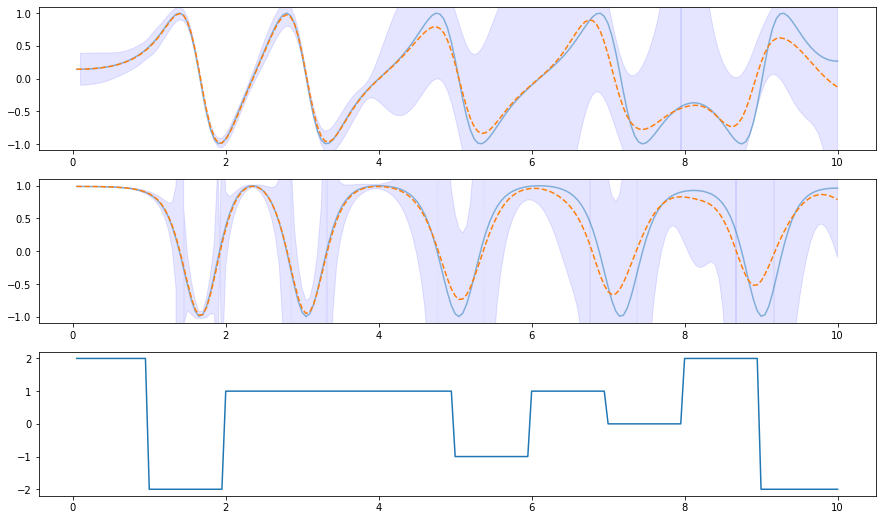

In [41]:
# Check trajectory
start = 0
end = 200

fig = plt.figure(figsize=(15, 9))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

# Plot cos q = x
ax1.plot(t_span.detach().numpy()[start:end], obs[start:end, 0].detach().numpy(), alpha=0.5)

# Plot sin q = y
ax2.plot(t_span.detach().numpy()[start:end], obs[start:end, 1].detach().numpy(), alpha=0.5)

# Plot control for reference
ax3.plot(t_span.detach().numpy()[start:end], controls[start+1:end+1])

qs = []
for i in range(num_ensumble):
    qs.append(ests[i].y[:, start:end])
    
mean_q = np.stack(qs, axis=2).mean(2)
std_q = np.stack(qs, axis=2).std(2)

ax1.plot(t_span.detach().numpy()[start:end], mean_q[0, :], '--')  # LNN
ci1 = 1.96 * std_q[0, :] / mean_q[0, :]
ax1.fill_between(t_span.detach().numpy()[start:end],
                (mean_q[0, start:end] - ci2[start:end]),
                (mean_q[0, start:end] + ci2[start:end]),
                color='b',
                alpha=.1)

ax2.plot(t_span.detach().numpy()[start:end], mean_q[1, :], '--')  # LNN
ci2 = 1.96 * std_q[1, :] / mean_q[1, :]
ax2.fill_between(t_span.detach().numpy()[start:end],
                (mean_q[1, start:end] - ci2[start:end]),
                (mean_q[1, start:end] + ci2[start:end]),
                color='b',
                alpha=.1)

ax1.set_ylim([-1.1, 1.1])
ax2.set_ylim([-1.1, 1.1])

### Plot Phase Space Trajectory

In [ ]:
length = 100
# Plot Phase Space traj
th = torch.atan(obs[:length, 1] / obs[:length, 0])
thdot = obs[:length, 2]

est_th = torch.atan(torch.tensor(est.y[1, :length] / est.y[0, :length]))
est_thdot = est.y[2, :length]

fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(th, thdot)
plt.scatter(est_th, est_thdot)

ax.set_xlabel("q")
ax.set_ylabel("dq")
ax.set_title("Phase Diagram")
None

### Plot Mass Matrix

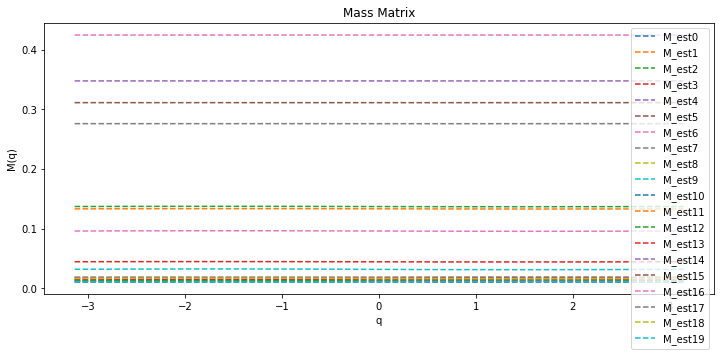

In [43]:
n_grid = 50
x = torch.linspace(-np.pi, np.pi, n_grid)

M_ests = []

    
for j in range(num_ensumble):
    M_est = np.zeros(x.shape)
    for i in range(n_grid):
        q = torch.stack([torch.cos(x[i]), torch.sin(x[i])])
        M_est[i] = test_models[j].defunc.m.massMatrixNet(q.view(1, -1)).detach().cpu()[0, 0, 0]
    M_ests.append(M_est)


M_true = torch.ones(M_ests[0].shape)

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
# ax.plot(x.detach().numpy(), M_true, label='M_true', alpha=0.5)

for j in range(num_ensumble):
    ax.plot(x.detach().numpy(), M_ests[j], '--', label='M_est{}'.format(j))

ax.legend()
# ax.set_ylim([-0.00, 0.001])
ax.set_xlabel("q")
ax.set_ylabel("M(q)")
ax.set_title("Mass Matrix")
None

### Plot Potential

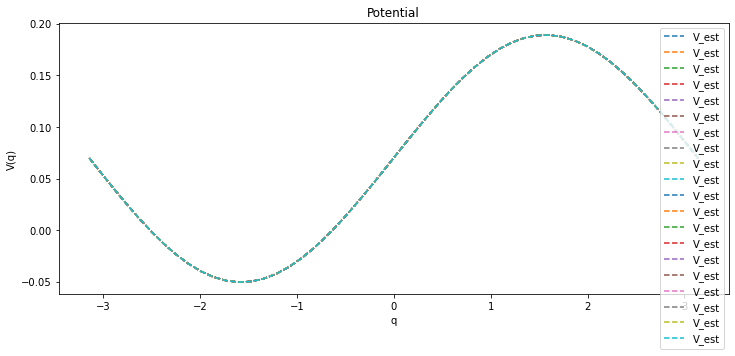

In [44]:
n_grid = 50
x = torch.linspace(-np.pi, np.pi, n_grid)

V_true = 1. * 10 * torch.sin(x)

Vs_est = []

for j in range(num_ensumble):
    V_est = torch.zeros(x.shape)
    for i in range(n_grid):
        q = torch.stack([torch.cos(x[i]), torch.sin(x[i])])
        V_est[i] = test_models[0].defunc.m.potentialNet(q.view(1, -1)).detach().cpu()
    Vs_est.append(V_est)

# V_est = V_est - min(V_est)

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
# ax.plot(x.detach().numpy(), V_true, label='V_true', alpha=0.5)

for j in range(num_ensumble):
    ax.plot(x.detach().numpy(), Vs_est[j], '--', label='V_est')
    

ax.legend()
ax.set_xlabel("q")
ax.set_ylabel("V(q)")
ax.set_title("Potential")
None

### Plot Control

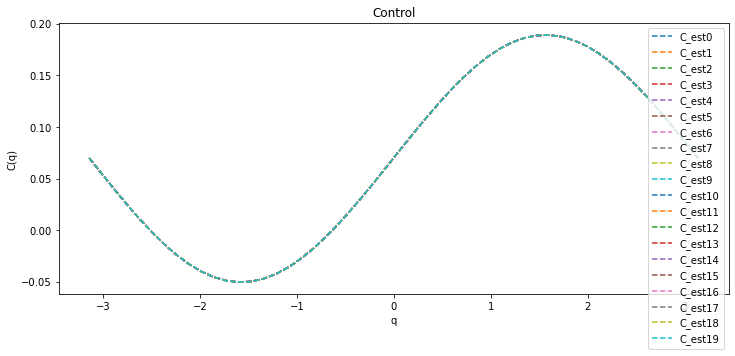

In [45]:
n_grid = 50
x = torch.linspace(-np.pi, np.pi, n_grid)

Cs_est = []

for j in range(num_ensumble):
    C_est = torch.zeros(x.shape)
    for i in range(n_grid):
        q = torch.stack([torch.cos(x[i]), torch.sin(x[i])])
        C_est[i] = test_models[0].defunc.m.controlNet(q.view(1, -1)).detach().cpu()
    Cs_est.append(V_est)

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)

for j in range(num_ensumble):
    ax.plot(x.detach().numpy(), Cs_est[j], '--', label='C_est{}'.format(j))

ax.legend()
ax.set_xlabel("q")
ax.set_ylabel("C(q)")
ax.set_title("Control")
None

## Conclusion